In [6]:
pip install pandas-profiling[notebook]

ERROR: phik 0.11.2 has requirement scipy>=1.5.2, but you'll have scipy 1.5.0 which is incompatible.



  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27090 sha256=8592a1a56660219baf0090305a1c8d0e56346b0202ebfacd133a9d536fffbea8
  Stored in directory: c:\users\света\appdata\local\pip\cache\wheels\23\14\6e\4be5bfeeb027f4939a01764b48edd5996acf574b0913fe5243
  Created wheel for phik: filename=phik-0.11.2-py3-none-any.whl size=1107421 sha256=8135c4435f8090716fb6a69e1ed277a276b42759d75381350b21bc2ce16713b2
  Stored in directory: c:\users\света\appdata\local\pip\cache\wheels\72\9a\23\097c93fd8341220d92674891b6a9a30f0e389719d9b7291bd2
Successfully built htmlmin phik
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.47.0
    Uninstalling tqdm-4.47.0:
      Successfully uninstalled tqdm-4.47.0


In [488]:
from pandas import Series
import pandas as pd
import numpy as np
import pandas_profiling
import statistics
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score, accuracy_score, precision_score, recall_score

In [325]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 1))
    sns.boxplot(x=column, y='default', data=data[data['sample'] == 1], ax=ax, orient='h')
    plt.xticks(rotation=0)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [326]:
# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42
# фиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

In [456]:
# подгружаем датасеты
DATA_DIR = 'C:/Users/Света/JupyterNotebook/datasets/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')

In [457]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True)
data.head()

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      74835  22MAR2014       GRD   M   29   Y        Y                0   
1      17527  24JAN2014       SCH   F   39   N        N                5   
2      75683  23MAR2014       UGR   M   50   Y        Y                0   
3      26883  03FEB2014       SCH   M   56   N        N                0   
4      28862  04FEB2014       GRD   F   38   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.271884                3             50             1   
1          0  -1.504999                2             50             1   
2          0  -1.691339                1             50             1   
3          0  -2.374182                1             40             1   
4          0  -2.487502                0             80             2   

   work_address  income  sna  first_time foreign_passport  sample  default  
0             2   50000    1           4                N       0      NaN  
1             2    5000    4           3                N       0      NaN  
2             2   30000    1           3                Y       0      NaN  
3             2   17000    1           3                N       0      NaN  
4             3  120000    1           3                N       0      NaN

**Описания полей**

- client_id - идентификатор клиента
- app_date - дата подачи заявки
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- score_bki - скоринговый балл по данным из БКИ
- bki_request_cnt - количество запросов в БКИ
- region_rating - рейтинг региона
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- foreign_passport - наличие загранпаспорта
- default - флаг дефолта по кредиту

In [33]:
# посмотрим на данные с помощью pandas profiling
pandas_profiling.ProfileReport(data)

Summarize dataset:   0%|          | 0/33 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

В данных о клиентах присутствуют переменные всех типов, не все имеют числовую запись.  
Виден дисбаланс классов в целевой переменной default.  
Пропуски встречаются только в информации об образовании клиентов. **Заменим пропуски в поле 'education' на самые часто встречающиеся значения:**

In [458]:
data['education'].fillna(statistics.mode(data['education']), inplace=True)

In [459]:
# преобразуем значения app_date в даты
data['app_date'] = pd.to_datetime(data['app_date'], format='%d%b%Y')

**Все признаки сгруппируем в три категории** по типу их обработки (категориальные, бинарные и числовые) для дальнейшего удобного анализа:

In [460]:
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные переменные
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time']
# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'income',
            'bki_request_cnt', 'region_rating', 'score_bki']

## Числовые переменные

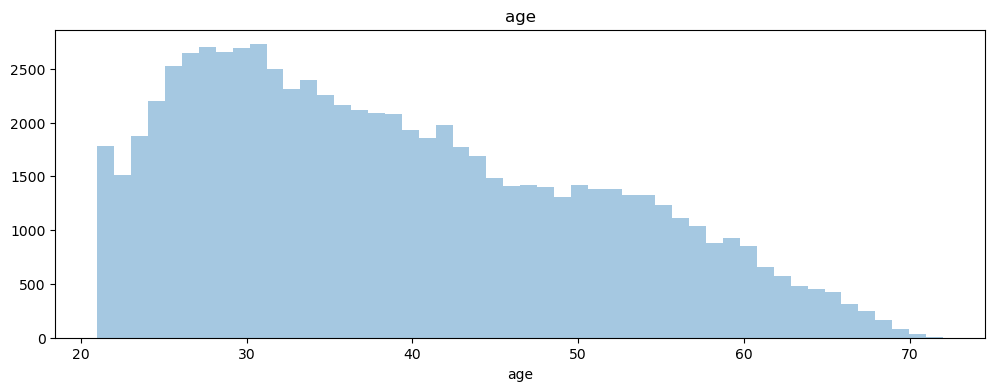

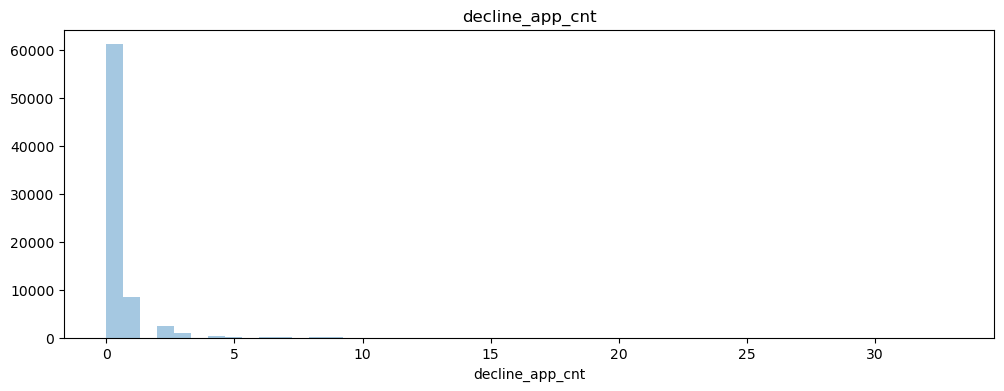

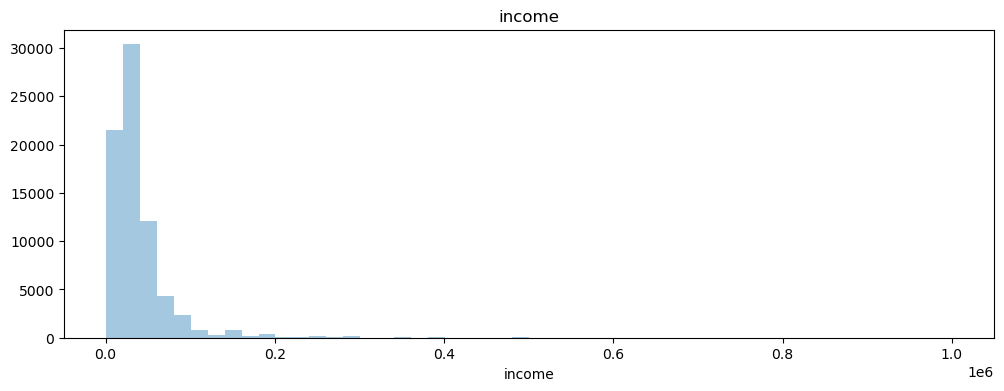

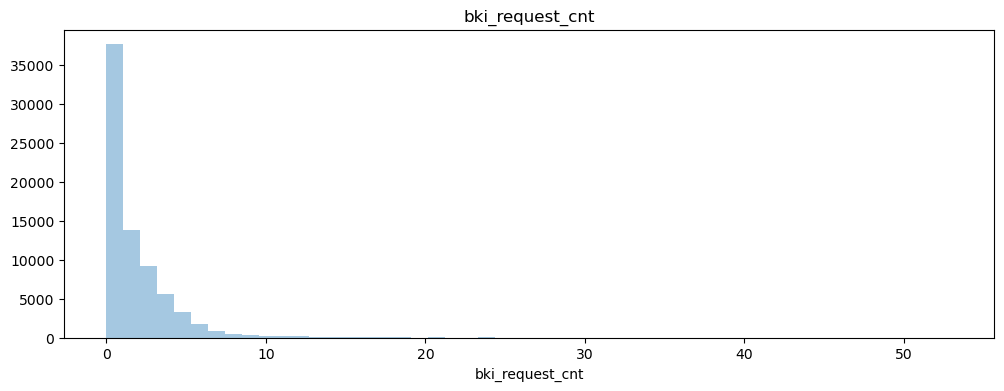

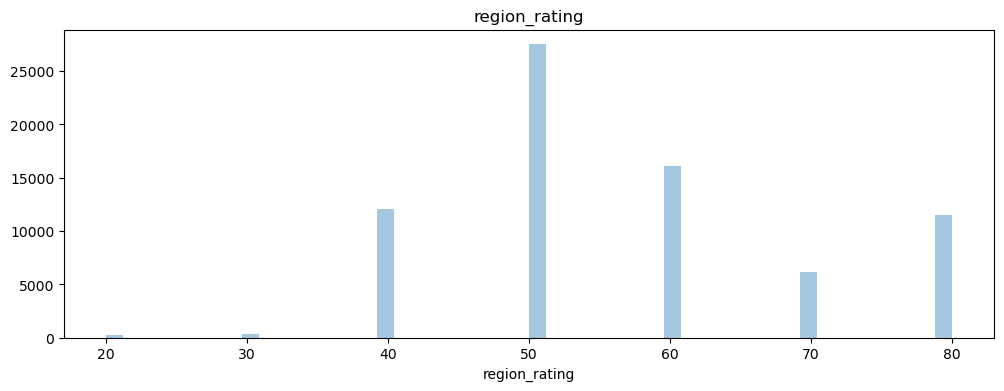

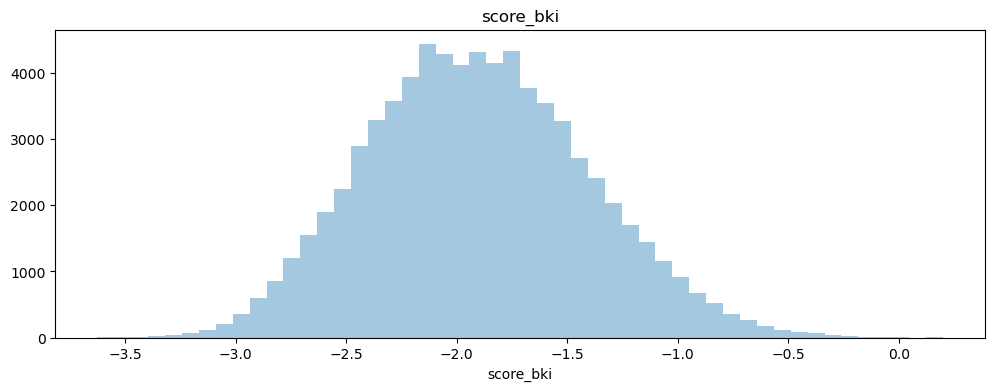

In [428]:
# посмотрим на распределение числовых признаков
for i in num_cols:
    plt.figure(figsize=(12, 4))
    sns.distplot(data[data['sample'] == 1][i].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

На гистограммах выше видно, что распределения переменных 'age', 'decline_app_cnt', 'income' и 'bki_request_cnt' имеют тяжёлый правый хвост. У 'score_bki' - нормальное распределение, но все значения отрицательны. 

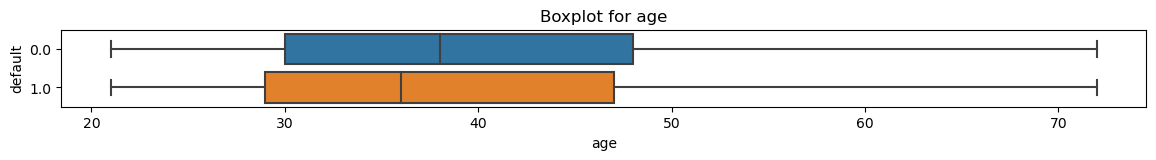

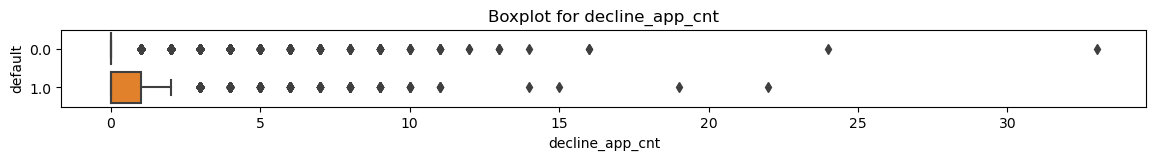

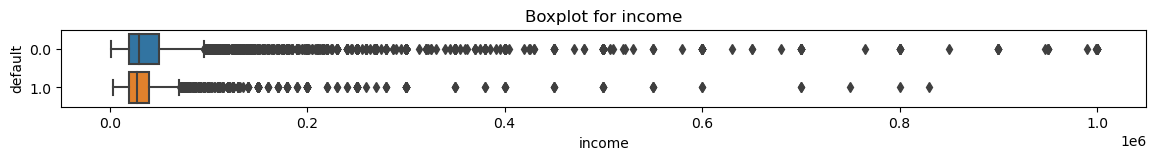

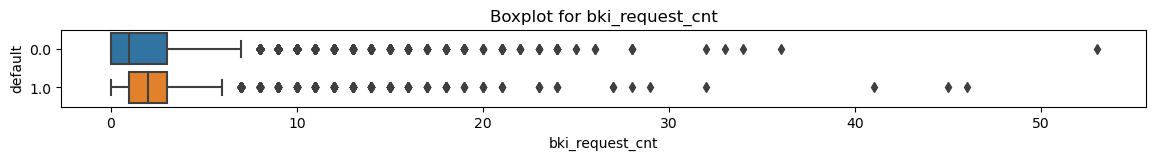

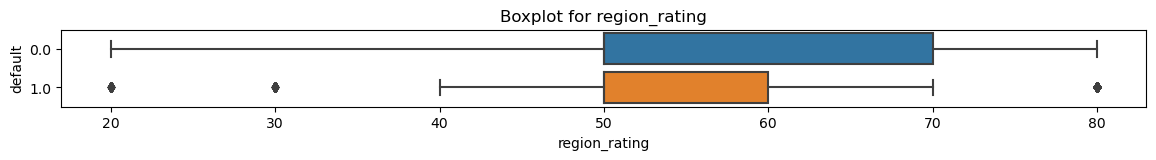

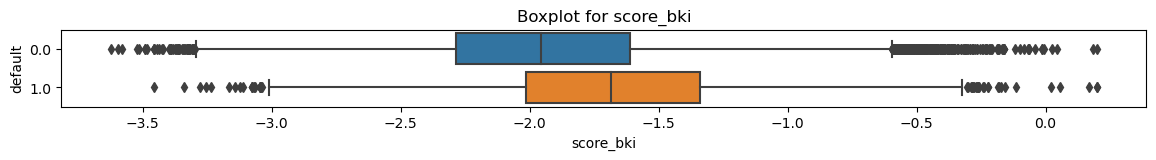

In [429]:
# посмотрим на наличие выбросов в данных
for i in num_cols:
    get_boxplot(i)

Выбросы в decline_app_cnt: 83% значений в этом признаке - нулевые. На фоне этого, все, что выше ~2 отмечено как выброс. Можно предположить, что в выборке есть некоторые немногочисленные клиенты с высоким количеством отказов. Не будем их удалять.  
Income: довольно много "выбросов" на боксплоте, но здесь также можно предположить наличие клиентов с высокими доходами.  
Данные score_bki оставим как есть, поскольку распределение нормальное.

Для того чтобы сделать распределение числовых переменных более нормальным, **прологарифмируем их значения переменных 'age', 'decline_app_cnt', 'income' и 'bki_request_cnt':**

In [461]:
for i in ['age', 'decline_app_cnt', 'income', 'bki_request_cnt']:
    data[i] = data[i].apply(lambda w: np.log(w+1))

Построим графики распределения логарифмированных переменных:

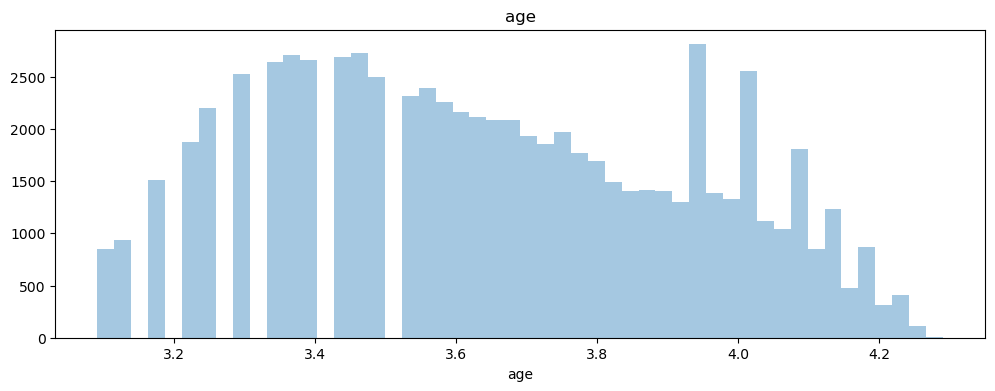

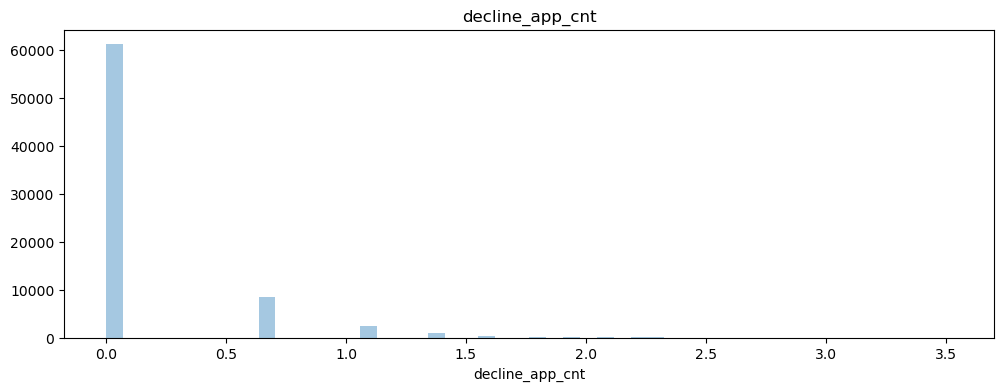

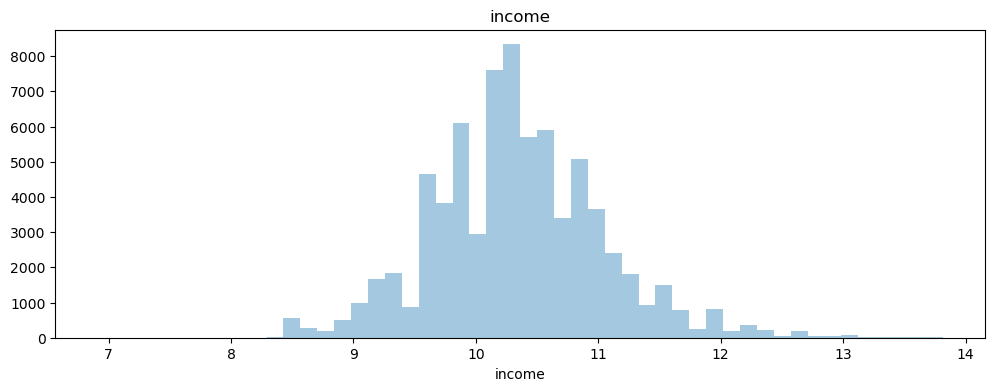

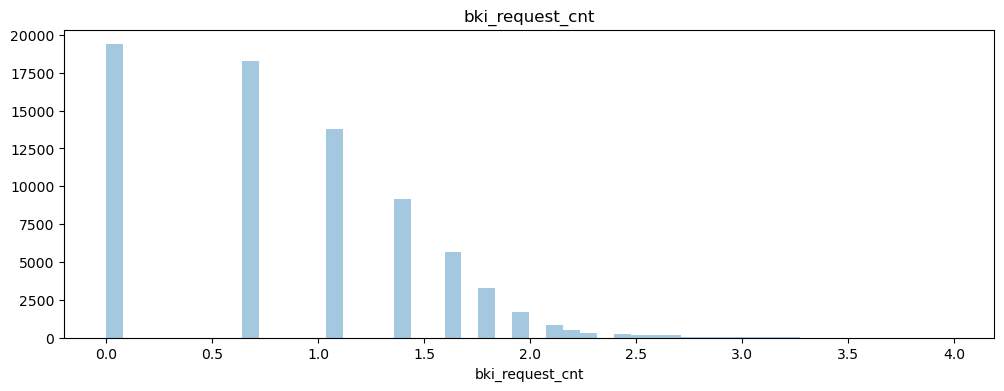

In [431]:
for i in ['age', 'decline_app_cnt', 'income', 'bki_request_cnt']:
    plt.figure(figsize=(12, 4))
    sns.distplot(data[data['sample'] == 1][i].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

Распределения age и income стало ближе к нормальному. Посмотрим еще раз на боксплоты:

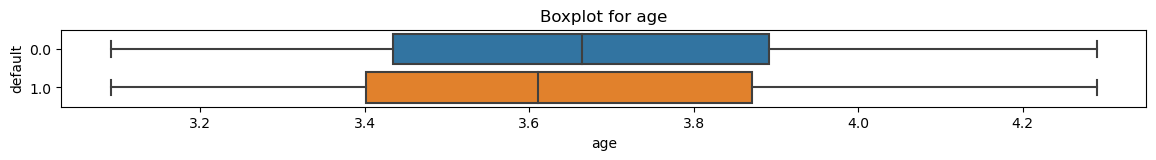

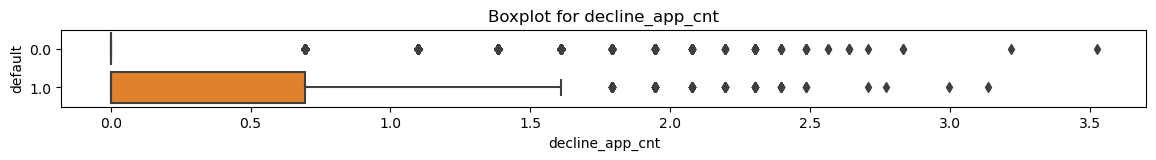

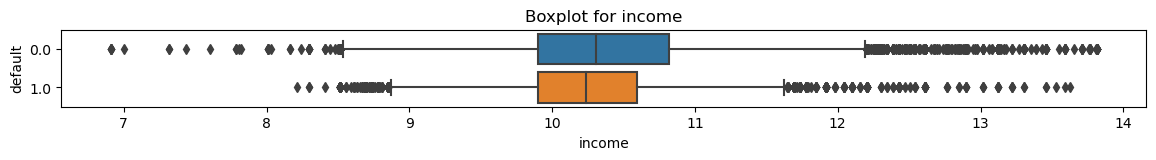

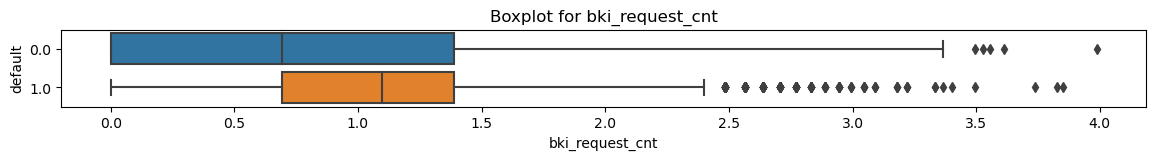

In [432]:
for i in ['age', 'decline_app_cnt', 'income', 'bki_request_cnt']:
    get_boxplot(i)

На основе графиков выше можно сделать следующие выводы:
- Дефолтные клиенты в среднем младше
- Дефолтные клиенты в среднем имеют большее количество отмененных заявок
- Дефолтные клиенты в среднем имеют больше запросов в БКИ
- Дефолтные клиенты в среднем имеют более низкий доход

**Оценим корреляцию Пирсона для непрерывных переменных**

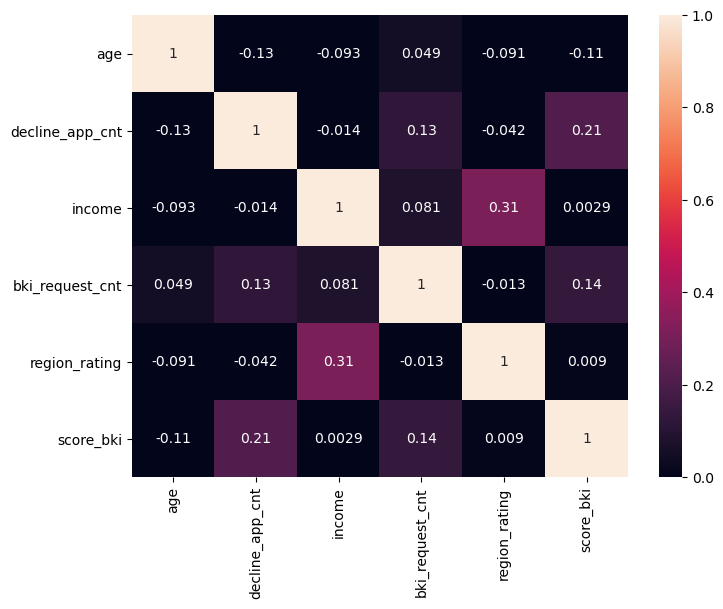

In [433]:
plt.rcParams['figure.figsize'] = (8,6)
sns.heatmap(data[data['sample'] == 1][num_cols].corr(), vmin=0, vmax=1, annot = True)

Наибольшая корреляция наблюдается между Income и Region_rating - 0.3. В целом же наблюдается слабая корреляция числовых признаков друг с другом.

**Для оценки значимости числовых переменных** будем использовать функцию f_classif из библиотеки sklearn.  
В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для модели.

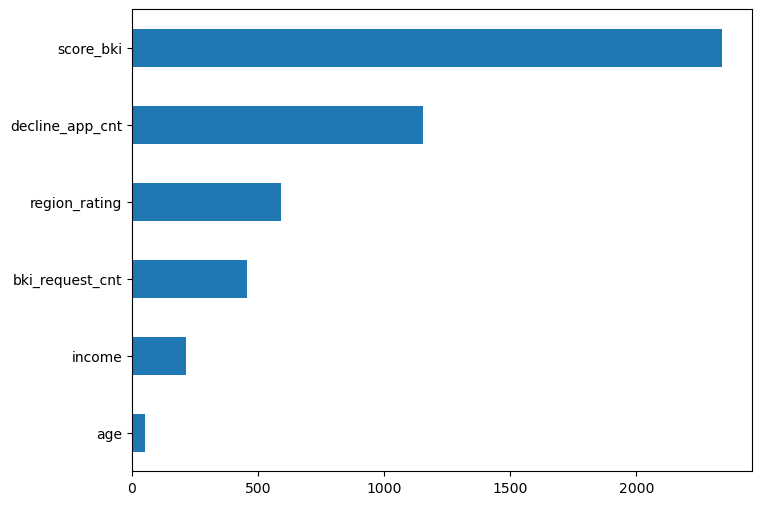

In [434]:
imp_num = pd.Series(f_classif(data[data['sample'] == 1][num_cols], data[data['sample'] == 1]['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

**Наиболее значимыми из числовых признаков являются score_bki, decline_app_cnt и region_rating.**

## Категориальные переменные

Применим LabelEncoder ко всему набору бинарных переменных.

In [462]:
# для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

# убедимся в преобразовании
data.head()

client_id   app_date education  sex       age  car  car_type  \
0      74835 2014-03-22       GRD    1  3.401197    1         1   
1      17527 2014-01-24       SCH    0  3.688879    0         0   
2      75683 2014-03-23       UGR    1  3.931826    1         1   
3      26883 2014-02-03       SCH    1  4.043051    0         0   
4      28862 2014-02-04       GRD    0  3.663562    0         0   

   decline_app_cnt  good_work  score_bki  bki_request_cnt  region_rating  \
0         0.000000          0  -2.271884         1.386294             50   
1         1.791759          0  -1.504999         1.098612             50   
2         0.000000          0  -1.691339         0.693147             50   
3         0.000000          0  -2.374182         0.693147             40   
4         0.000000          0  -2.487502         0.000000             80   

   home_address  work_address     income  sna  first_time  foreign_passport  \
0             1             2  10.819798    1           4                 0   
1             1             2   8.517393    4           3                 0   
2             1             2  10.308986    1           3                 1   
3             1             2   9.741027    1           3                 0   
4             2             3  11.695255    1           3                 0   

   sample  default  
0       0      NaN  
1       0      NaN  
2       0      NaN  
3       0      NaN  
4       0      NaN

In [463]:
# преобразуем education в числа, создав словарь, соответствующий уровню образования
education_dict = {'SCH': 0, 'GRD': 1, 'UGR': 2, 'PGR': 3, 'ACD': 4}
data['education'] = data['education'].replace(to_replace=education_dict)

**Оценим корреляцию Пирсона для категориальных и бинарных переменных**

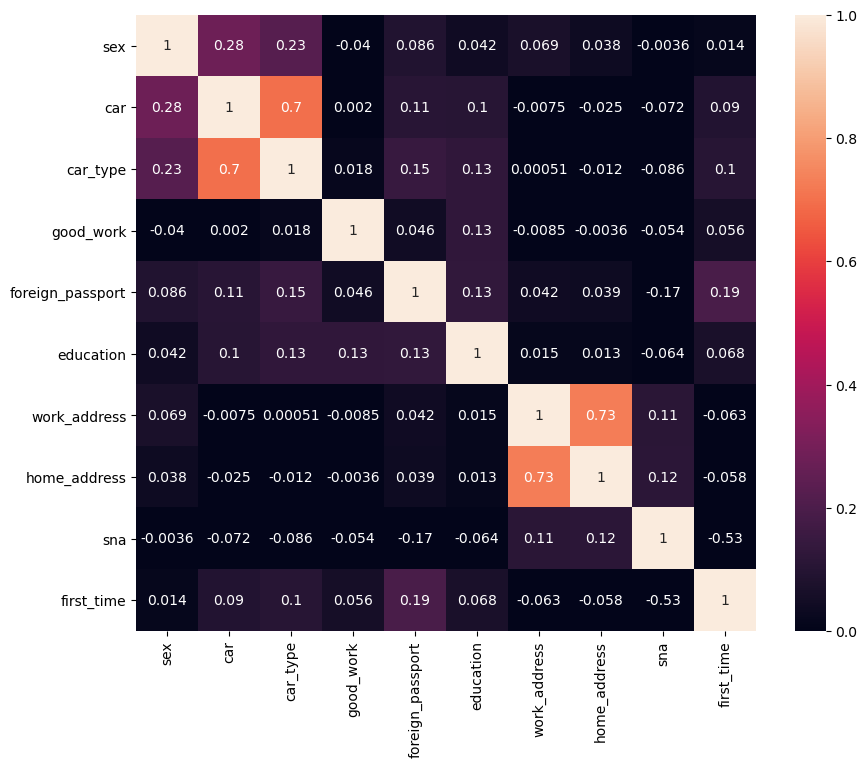

In [437]:
plt.rcParams['figure.figsize'] = (10,8)
sns.heatmap(data[data['sample'] == 1][bin_cols + cat_cols].corr(), vmin=0, vmax=1, annot = True)

**Для оценки значимости категориальных и бинарных переменных** будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

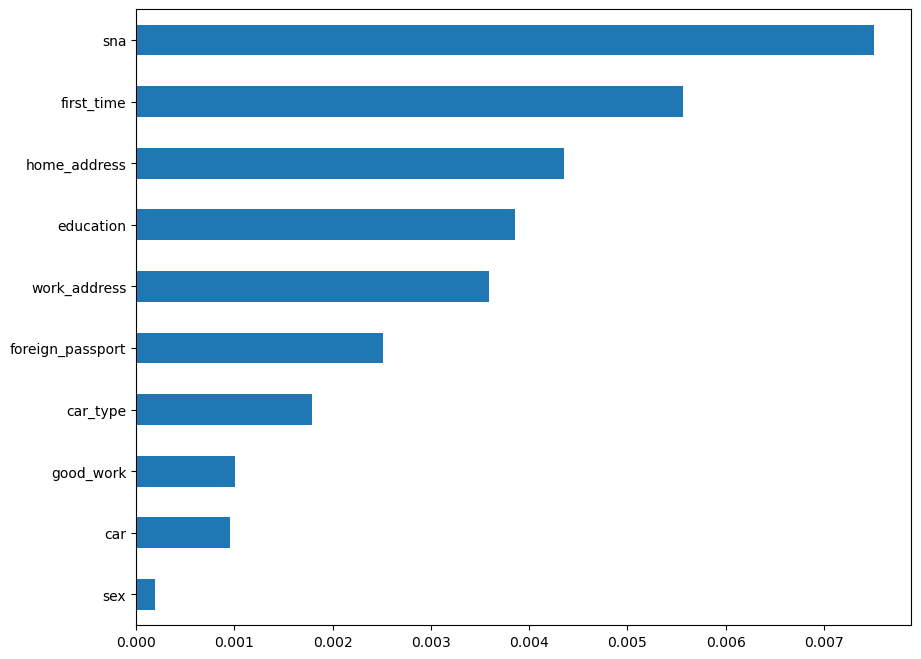

In [438]:
imp_cat = Series(mutual_info_classif(data[data['sample'] == 1][bin_cols + cat_cols], data[data['sample'] == 1]['default'],
                                     discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Признаки car и car_type, а также home_address и work_address мультиколлинеарны. При этом home_address и car_type более важны для модели, соответственно, их и оставим.

In [439]:
data.drop(columns=['work_address', 'car'], inplace=True)

**Наиболее значимыми из категориальных признаков являются sna, first_time и home_address.**

## Feature engineering

In [464]:
# вычислим количество дней, прошедшее с первой даты подачи заявки
data['days_from_1st_date'] = data['app_date'].apply(
    lambda x: (x - data['app_date'].min()).days)

In [294]:
data['days_from_1st_date'].unique()

array([ 80,  23,  81,  33,  34, 106,  32,  86,  22, 113,  55,  14, 102,
        70,  75,  31,  45,  90,  50, 109,  26,  54,  17,  15,  43,  91,
        65,  97,  51,  74,   7,  82,  77,  18, 107,  94,  83,  64, 118,
       117,  21,  85,  30,  10,  52,  35,  96,  72,  95,  60,   5,  63,
        68, 111,  56,  46,  59,   3,  29,  39,  41,  62,  28,  93, 114,
        49,  44,  84,  12,  76,  36,  61, 112,  48,  19,  53,  89,  38,
        92,  16, 116, 103,  88, 119,  40,  42,  11,  99,  58,  73, 101,
        27,  71,  78,   1,  57,  24,   8,   9, 104,  87, 105, 115,   2,
       110,  47,   6,  69,  79, 100,  25,  37,  13,  20,  67,  66, 108,
        98,   4,   0], dtype=int64)

In [465]:
# добавим показатель среднего дохода в регионе
mean_income_rat = data.groupby('region_rating')['income'].mean().to_dict()
data['mean_income_region'] = data['region_rating'].map(mean_income_rat)

In [466]:
# перезапишем группы переменных
bin_cols = ['sex', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'home_address', 'sna', 'first_time']
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt',
            'region_rating', 'score_bki', 'days_from_1st_date', 'mean_income_region']

Снова посмотрим на важность числовых:

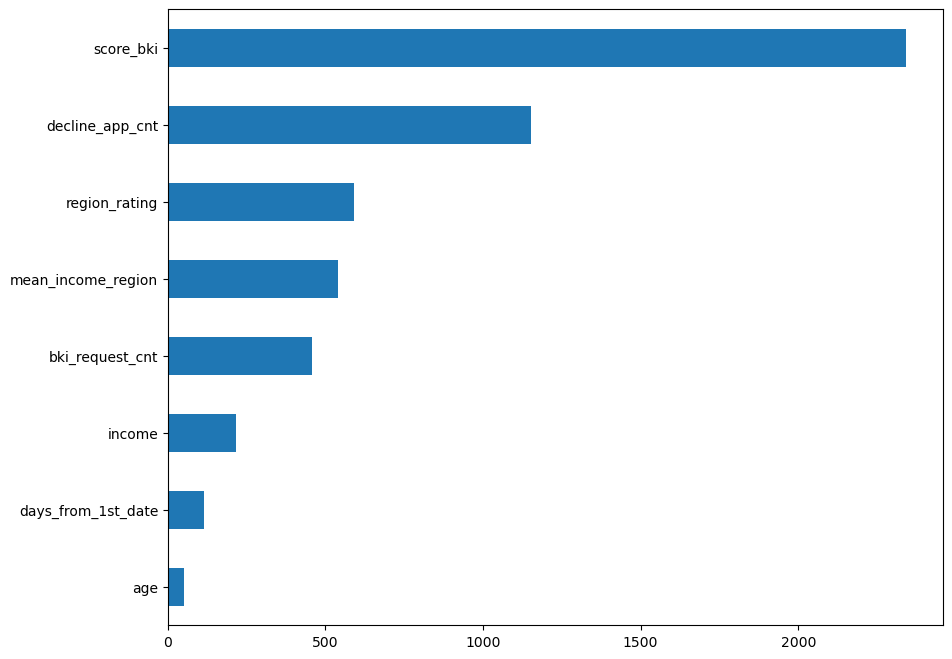

In [468]:
imp_num = pd.Series(f_classif(data[data['sample'] == 1][num_cols],
                              data[data['sample'] == 1]['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

In [469]:
# удалим исходный столбец app_date
data.drop(['app_date'], axis=1, inplace=True)

## Наивная модель

In [470]:
# подгружаем датасеты
DATA_DIR = 'C:/Users/Света/JupyterNotebook/datasets/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'train.csv')

Confusion matrix:
[[12933     0]
 [ 1827     0]]


[Text(0, 0.5, 'Predicted'), Text(0.5, 0, 'True')]

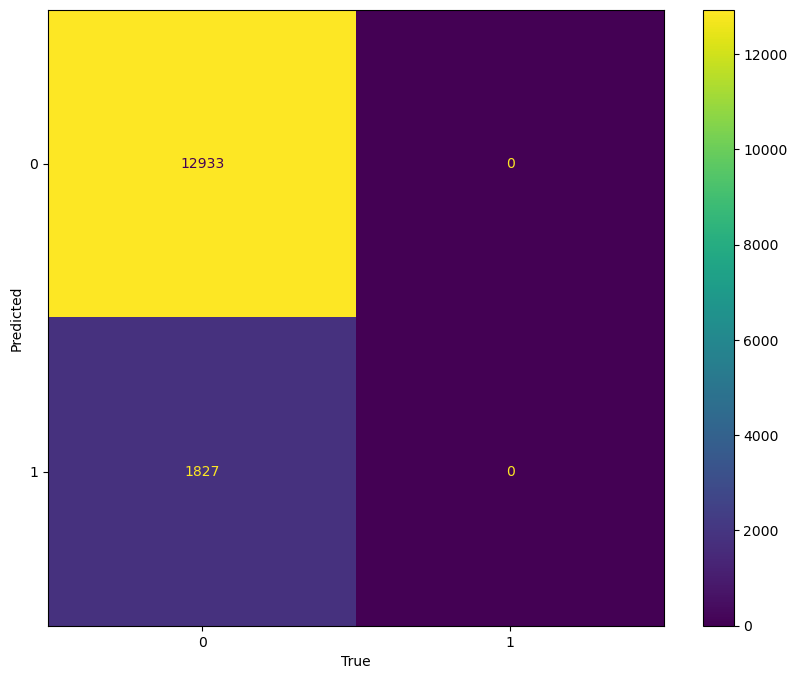

In [471]:
# замена пустых в education
df_train['education'].fillna(statistics.mode(df_train['education']), inplace=True)

# группировка признаков по типам данных
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time']
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'region_rating', 'score_bki']

# label encoding бинарных признаков
for column in bin_cols:
    df_train[column] = LabelEncoder().fit_transform(df_train[column])
    
# one-hot encoding категориальных признаков
df_train = pd.get_dummies(df_train, prefix=cat_cols, columns=cat_cols)

# разделим признаки и целевую переменную
X = df_train.drop(['default', 'client_id', 'app_date'], axis=1).values
y = df_train['default'].values  

# разделим данные на тестовые и обучающие
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)

# модель
lr = LogisticRegression(random_state=RANDOM_SEED)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n{}'.format(conf_mat))

cmd = ConfusionMatrixDisplay(conf_mat)
cmd.plot()
cmd.ax_.set(xlabel='True', ylabel='Predicted')

## Подготовка данных к ML и обучение модели

In [499]:
# соберем заново всю чистку данных из EDA

DATA_DIR = 'C:/Users/Света/JupyterNotebook/datasets/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')

df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True)
data['education'].fillna(statistics.mode(data['education']), inplace=True)
data['app_date'] = pd.to_datetime(data['app_date'], format='%d%b%Y')

bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time']
num_cols = ['age', 'decline_app_cnt', 'income',
            'bki_request_cnt', 'region_rating', 'score_bki']

for i in ['age', 'decline_app_cnt', 'income', 'bki_request_cnt']:
    data[i] = data[i].apply(lambda w: np.log(w+1))

for column in bin_cols:
    data[column] = LabelEncoder().fit_transform(data[column])

education_dict = {'SCH': 0, 'GRD': 1, 'UGR': 2, 'PGR': 3, 'ACD': 4}
data['education'] = data['education'].replace(to_replace=education_dict)

data['days_from_1st_date'] = data['app_date'].apply(
    lambda x: (x - data['app_date'].min()).days)

mean_income_rat = data.groupby('region_rating')['income'].mean().to_dict()
data['mean_income_region'] = data['region_rating'].map(mean_income_rat)

data.drop(columns=['work_address', 'car', 'app_date'], axis=1, inplace=True)

bin_cols = ['sex', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'home_address', 'sna', 'first_time']
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt',
            'region_rating', 'score_bki', 'days_from_1st_date', 'mean_income_region']

In [500]:
# get_dummies категориальных переменных
data = pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)

In [501]:
# cтандартизация числовых переменных отдельно для теста и трейна
data[data['sample'] == 1][num_cols] = pd.DataFrame(StandardScaler().fit_transform(
    data[data['sample'] == 1][num_cols]), columns=data[data['sample'] == 1][num_cols].columns)

data[data['sample'] == 0][num_cols] = pd.DataFrame(StandardScaler().fit_transform(
    data[data['sample'] == 0][num_cols]), columns=data[data['sample'] == 0][num_cols].columns)

In [502]:
# выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample', 'client_id'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'client_id'], axis=1)

In [503]:
X = train_data.drop(['default'], axis=1).values
y = train_data['default'].values  # наш таргет

In [504]:
# разделим данные на тестовые и обучающие
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_SEED)

In [505]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((36349, 29), (73799, 29), (73799, 28), (59039, 28), (14760, 28))

In [506]:
# обучим модель
lr = LogisticRegression(random_state=RANDOM_SEED)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

## Оценка качества модели

В качестве методов оценки прогностической способности модели используем ROC-анализ.

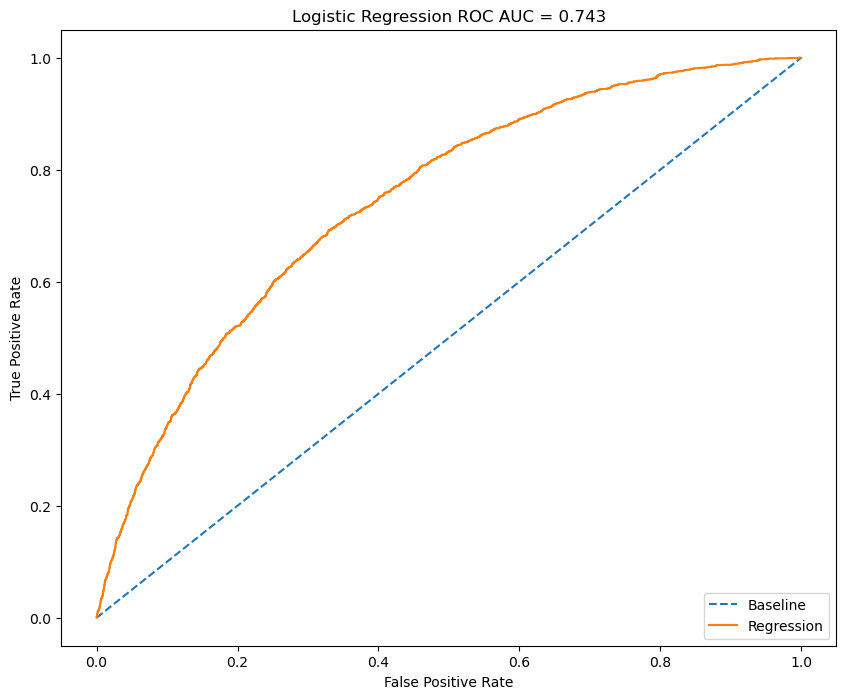

In [507]:
probs = lr.predict_proba(X_test)
probs = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [508]:
conf_mat = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n{}'.format(conf_mat))
print('accuracy_score:', accuracy_score(y_test, y_pred))
print('precision_score:', precision_score(y_test, y_pred))
print('recall_score:', recall_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred))

Confusion matrix:
[[12874    59]
 [ 1788    39]]
accuracy_score: 0.8748644986449865
precision_score: 0.3979591836734694
recall_score: 0.021346469622331693
f1_score: 0.040519480519480525


Имеем высокое значение ROC_AUC, при этом очень низкие значения precision и f1. Много ошибок 1 рода - FN - ложно отрицательных предсказаний (дефолт классифицирован как не-дефолт).

### Вариант модели с class_weight

**Попробуем уравновесить классы с помощью class_weight='balanced':**

In [509]:
lr_balance = LogisticRegression(random_state=RANDOM_SEED, class_weight='balanced')
lr_balance.fit(X_train, y_train)
y_pred = lr_balance.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n{}'.format(conf_mat))
print('accuracy_score:', accuracy_score(y_test, y_pred))
print('precision_score:', precision_score(y_test, y_pred))
print('recall_score:', recall_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred))

Confusion matrix:
[[8684 4249]
 [ 568 1259]]
accuracy_score: 0.6736449864498645
precision_score: 0.22857661583151778
recall_score: 0.6891078270388615
f1_score: 0.3432856169052488


Выросло количество ошибок второго рода, значения precision_score и f1_score стали лучше.

### Вариант модели с undersampling

Попробуем сделать undersampling данных для модели, чтобы уравновесить классы.

In [511]:
small_class = train_data[train_data['default'] == 1]
n = small_class.shape[0]
large_class = train_data[train_data['default'] == 0].iloc[:n, :]
train_balanced = pd.concat([large_class, small_class], sort=False, axis=0)

X = train_balanced.drop(['default'], axis=1).values
y = train_balanced['default'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_SEED)

lr_undersmpl = LogisticRegression(random_state=RANDOM_SEED)
lr_undersmpl.fit(X_train, y_train)
y_pred = lr_undersmpl.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n{}'.format(conf_mat))
print('accuracy_score:', accuracy_score(y_test, y_pred))
print('precision_score:', precision_score(y_test, y_pred))
print('recall_score:', recall_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred))

Confusion matrix:
[[1263  624]
 [ 578 1284]]
accuracy_score: 0.6793811683115497
precision_score: 0.6729559748427673
recall_score: 0.6895810955961332
f1_score: 0.6811671087533157


## Поиск параметров регуляризации

В этом примере мы рассмотрим поиск гиперпараметров GridSearchCV при помощи перебора параметров по сетке с последующей кросс-валидацией. 

In [512]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(lr_undersmpl, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 21.544346900318832


In [516]:
C_reg = best_model.best_estimator_.get_params()['C']
model = LogisticRegression(penalty='l2', C=C_reg)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n{}'.format(conf_mat))
print('accuracy_score:', accuracy_score(y_test, y_pred))
print('precision_score:', precision_score(y_test, y_pred))
print('recall_score:', recall_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred))

Confusion matrix:
[[1269  618]
 [ 581 1281]]
accuracy_score: 0.6801813817017871
precision_score: 0.674565560821485
recall_score: 0.6879699248120301
f1_score: 0.6812018080297794


## Submission

In [ ]:
train_data = data.query('sample == 1').drop(['sample', 'client_id'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'client_id'], axis=1)

In [ ]:
X_train = train_data.drop(['default'], axis=1)
y_train = train_data['default'].values
X_test = test_data.drop(['default'], axis=1)

In [ ]:
# проверяем
test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape

In [ ]:
model = LogisticRegression(penalty='l2', C=C_reg)
model.fit(X_train, y_train)

In [ ]:
y_pred_prob = model.predict_proba(X_test)[:, 1]

submit = pd.DataFrame(df_test.client_id)
submit['default'] = y_pred_prob
submit.to_csv('submission.csv', index=False)
submit.head(10)